# Inteligencia Artificial para la Predicción de Incremental de Presiones por Interferencia

Notebook para la competencia de YPF en conjunto con Fundación Sadoski

Autor: Matías Ezequiel Uncal Bressi


## Introducción

**Se presenta un ensemble de modelos.** Se plantea un clasificador + una regresión.

Para ambos se toma cada par Pozo Padre - Pozo Hijo y se construye la serie temporal (utilziando la Etapa del Pozo Hijo como medida) sobre la variable a predecir. Este enfoque simple generó una diferencia sustancial en la puntuación final.

Dentro de las variables generadas se encuentran:
* Diferencias porcentuales para las variables numéricas.
* Se agrega el valor 'anterior' de `delta_WHP`.
* Para el ángulo se utilizan las funciones trigonométricas que modelan mejor la idea de círculo (360° = 0°).

Otras variables que podrían ser útiles (pero que no fueron provistas y no se pueden derivar):
* `FECHA_EVENTO` Si bien está la ETAPA_HIJO, ésta solo da una idea de temporalidad respecto al Pozo Hijo, no al Padre. Si un Padre tiene interacciones con diversos Pozos Hijos, al no tener la fecha de cada evento no se puede realizar una trazabilidad de la presión en el Pozo Padre.
* `WHP_INYECTDA` No se si es constante o no. Si es siempre la misma para todos los Pozos Hijos, no tiene sentido agregarla. Pero si no es la misma, podría ser de gran utilidad. De hecho sería útil para dar una cota máxima de presión a inyectar en cada Etapa de cada Pozo Hijo.

## Nota sobre la puntuación y el envío final del CSV con el score

**Para ambos modelos se utiliza información de Etapas anteriores** en las variables predictoras. **Nunca información futura** ya que si se quiere poner en práctica lo aquí expuesto sería imposible en la vida real.

Es por esto que no se generan variables con granularidad Pozo Padre - Pozo Hijo sin tener en cuenta la Etapa en cuestión.

Ahora bien, en el 1° meetup desde YPF dijeron que sí se podía. Por lo que al final, luego de realizar la predicción para el dataset de evaluación, se promedia el valor estimado con una media movil del valor real.


## Librerías utilizadas

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.9 MB/s 


In [ ]:
import io
import warnings
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

%matplotlib inline
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

## Se cargan los archivos a utilizar

In [ ]:
uploaded = files.upload()

Saving Dataset evaluación.csv to Dataset evaluación.csv
Saving Dataset participantes.csv to Dataset participantes.csv


In [ ]:
df_train = pd.read_csv(io.StringIO(uploaded['Dataset participantes.csv'].decode('utf-8')), index_col='ID_FILA')
df_eval = pd.read_csv(io.StringIO(uploaded['Dataset evaluación.csv'].decode('utf-8')), index_col='ID_FILA')

## Análisis del dataset de entrenamiento

Se hace foco en la variable a predecir.



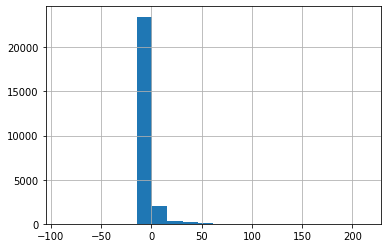

In [ ]:
# Vemos la distribución

df_train['delta_WHP'].hist(bins=20)

In [ ]:
# Vemos que la basta mayoría son exactamente 0

df_train['delta_WHP'].value_counts()

0.0      23053
0.6         43
0.7         42
1.3         40
0.3         40
         ...  
88.4         1
45.7         1
20.2         1
156.6        1
67.8         1
Name: delta_WHP, Length: 609, dtype: int64

Coef de asimetría: 3.47


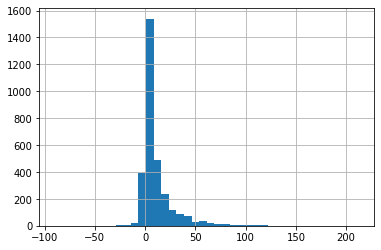

In [ ]:
# Vemos la distribución de la variable a predecir sin contar los 0. Vemos que es muy asimétrica y tiene valores negativos.
# Esto último complica la posibilidad de realizar una transformación logarítmica de la misma.

print('Coef de asimetría: ' + str(round(df_train.loc[df_train['delta_WHP'] != 0, 'delta_WHP'].skew(), 2)))
df_train.loc[df_train['delta_WHP'] != 0, 'delta_WHP'].hist(bins=40)

Se concluye que lo mejor es realizar 2 modelos:
*   Uno de clasificación (ocurre o no ocurre frac-hit - `delta_WHP != 0` o `delta_WHP == 0`)

*   Uno de regresión para tratar de estimar el valor de delta_WHP

## Funciones de limpieza / Generación de features

In [ ]:
def percentage_dif(current, previous):
    # Devuelve la diferencia porcentual entre 2 valores
    return round((current - previous) / previous, 3)

def clean_df(df):
    
    # Se ordena, porque se iterará sobre el dataset y se toma como una serie temporal cada etapa entre un Padre-Hijo
    df.sort_values(['PAD_HIJO', 'HIJO', 'PADRE', 'ETAPA_HIJO'], inplace = True)
    df.reset_index(inplace = True)
    
    # Se generan algunas variables dicotómicas
    df['FLUIDO'] = np.where(df['FLUIDO'] == 'GAS', 1, 0)
    df['LINEAMIENTO'] = np.where(df['LINEAMIENTO'] == 'SI', 1, 0)
    df['ESTADO'] = np.where(df['ESTADO'] == 'Abierto', 1, 0)
    
    # Se corrigen algunos valores
    df['AZ'] = np.where(df['AZ'] < 0, 0, df['AZ'])
    df['WHP_i'] = np.where(df['WHP_i'] < 0, 0, df['WHP_i'])
    df['D3D'] = np.where(df['D3D'] > 100 * df['D2D'], df['D3D'] / 1000, df['D3D'])
    df['D2D'] = np.where(df['D2D'] > 100 * df['D3D'], df['D2D'] / 1000, df['D2D'])
    
    # Se generan nuevas variables
    # ---------------------------
      # Variable dicotómica que se utilizará como target para el clasificador (Hay / No hay Frac-Hit)
    df['delta_WHP_0'] = np.where(df['delta_WHP'] == 0, 0, 1)

      # Para el ángulo trabajamos con las funciones seno / coseno
    df['sen_AZ'] = round(np.sin(df['AZ']*np.pi/180), 3)
    df['cos_AZ'] = round(np.cos(df['AZ']*np.pi/180), 3)
    
      # Estandarizo las distancias y agrego la presión inicial también estandarizada
    df['D3D'] = round((df['D3D'] - np.mean(df['D3D'])) / np.std(df['D3D']), 3)
    df['D2D'] = round((df['D2D'] - np.mean(df['D2D'])) / np.std(df['D2D']), 3)            
    df['DZ'] = round((df['DZ'] - np.mean(df['DZ'])) / np.std(df['DZ']), 3)
    df['WHP_i_std'] = round((df['WHP_i'] - np.mean(df['WHP_i'])) / np.std(df['WHP_i']), 3)

      # Diferencia porcentual para algunas variables (se calculan más abajo)
    df['pct_dif_D3D'] = np.NaN
    df['pct_dif_D2D'] = np.NaN
    df['pct_dif_DZ'] = np.NaN
    df['pct_dif_WHP_i'] = np.NaN
      
      # Diferencia entre etapas
    df['dif_ETAPA_HIJO'] = np.NaN

      # El valor anterior del delta_WHP
    df['ant_delta_WHP'] = np.NaN

    # Media móvil y valor posterior de delta_WHP (para mejorar score, solo se utilizan al final, no influyen en el modelo)
    df['media_movil_delta_WHP'] = np.NaN
    df['pos_delta_WHP'] = np.NaN
    
    # Ahora si vamos a iterar sobre el dataset ordenado, y vamos a calcular los valores de diferencia_porcentual / etc
    last_idx = 0
    for i in range(1, df.shape[0]-1):
        
        # Si la fila anterior tiene el mismo Padre y el mismo Hijo, podemos calcular las diferencias
        if (df.at[i, 'PADRE'] == df.at[i-1, 'PADRE']) and (df.at[i, 'HIJO'] == df.at[i-1, 'HIJO']):
            
            df.at[i, 'pct_dif_D3D'] = percentage_dif(df.at[i, 'D3D'], df.at[i-1, 'D3D'])
            df.at[i, 'pct_dif_D2D'] = percentage_dif(df.at[i, 'D2D'], df.at[i-1, 'D2D'])
            df.at[i, 'pct_dif_DZ'] = percentage_dif(df.at[i, 'DZ'], df.at[i-1, 'DZ'])
            df.at[i, 'pct_dif_WHP_i'] = percentage_dif(df.at[i, 'WHP_i'], df.at[i-1, 'WHP_i'])
            
            df.at[i, 'dif_ETAPA_HIJO'] = df.at[i, 'ETAPA_HIJO'] - df.at[i-1, 'ETAPA_HIJO']

            df.at[i, 'ant_delta_WHP'] = df.at[i-1, 'delta_WHP']
            
            if (df.at[i, 'PADRE'] == df.at[i+1, 'PADRE']) and (df.at[i, 'HIJO'] == df.at[i+1, 'HIJO']):

                df.at[i, 'media_movil_delta_WHP'] = (df.at[i-1, 'delta_WHP'] + df.at[i+1, 'delta_WHP']) / 2
                df.at[i, 'pos_delta_WHP'] = df.at[i+1, 'delta_WHP']

              
        else:

            last_idx = i

            if (df.at[i, 'PADRE'] == df.at[i+1, 'PADRE']) and (df.at[i, 'HIJO'] == df.at[i+1, 'HIJO']):

                df.at[i, 'pos_delta_WHP'] = df.at[i+1, 'delta_WHP']
            
    return df

## Proceso de entrenamiento

In [ ]:
# Se cargan los dataframes
# Se concatenan el de evaluación con el de entrenamiento debido a que necesitamos información de las etapas anteriores

df_train['TIPO'] = 'Train'
df_eval['TIPO'] = 'Eval'
df_total = pd.concat([df_train, df_eval])
df_total = clean_df(df_total)
df_train = clean_df(df_train)

In [ ]:
# Vemos una muestra de los datos procesados

df_total.head()

,ID_FILA,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO,TIPO,delta_WHP_0,sen_AZ,cos_AZ,WHP_i_std,pct_dif_D3D,pct_dif_D2D,pct_dif_DZ,pct_dif_WHP_i,dif_ETAPA_HIJO,ant_delta_WHP,media_movil_delta_WHP,pos_delta_WHP
0,11490,Pozo 461-Pozo 1-19,Campo A,1,PAD-1,Pozo 461,19,Pozo 1,-1.621,-1.615,-0.707,278.349032,0.0,0,108.6,-1.3,1,Train,1,-0.989,0.145,-0.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11353,Pozo 461-Pozo 1-22,Campo A,1,PAD-1,Pozo 461,22,Pozo 1,-1.604,-1.598,-0.648,266.146420,1.0,0,104.6,3.6,1,Train,1,-0.998,-0.067,-0.272,-0.010,-0.011,-0.083,-0.037,3.0,-1.3,0.55,2.4
2,11398,Pozo 461-Pozo 1-24,Campo A,1,PAD-1,Pozo 461,24,Pozo 1,-1.591,-1.585,-0.640,278.815790,0.0,0,105.9,2.4,1,Train,1,-0.988,0.153,-0.261,-0.008,-0.008,-0.012,0.012,2.0,3.6,1.15,-1.3
3,11403,Pozo 461-Pozo 1-30,Campo A,1,PAD-1,Pozo 461,30,Pozo 1,-1.613,-1.607,-0.577,279.782291,0.0,0,106.0,-1.3,1,Train,1,-0.985,0.170,-0.261,0.014,0.014,-0.098,0.001,6.0,2.4,NaN,NaN
4,11486,Pozo 461-Pozo 4-1,Campo A,1,PAD-1,Pozo 461,1,Pozo 4,-1.635,-1.629,-0.674,264.238475,0.0,0,108.4,2.3,1,Train,1,-0.995,-0.100,-0.242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5


In [ ]:
# Se separa en train (70%) / test (30%)
# Notar que 'pos_delta_WHP' y 'media_movil_delta_WHP' NO se encuentran presentes en la lista de variables a utilizar

X = df_train[[
        'CAMPO', 'PADRE', 'HIJO', 'PAD_HIJO',                                 # Variables categóricas
        'FLUIDO', 'LINEAMIENTO', 'ESTADO',                                    # Variables dicotómicas
        'ETAPA_HIJO', 'D3D', 'D2D', 'DZ', '#_BARRERAS', 'WHP_i', 'WHP_i_std', # Variables numéricas (con sus respectivas transformaciones)
        'pct_dif_D3D', 'pct_dif_D2D', 'pct_dif_DZ', 'pct_dif_WHP_i',          # Variables generadas
        'dif_ETAPA_HIJO', 'sen_AZ', 'cos_AZ', 'ant_delta_WHP',                # Variables generadas 
        ]]

y = df_train[['delta_WHP', 'delta_WHP_0']]                                    # Se toman la variable dicotómica y la numérica, para los dos modelos distintos

# Se estratifica por la variable 'CAMPO'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify = X['CAMPO'])

**Nota sobre el tratamiento de features de tipo categórico.**

Si bien se pueden realizar distintos tipos de trabajos (crear variables dicotómicas, imputar valores promedio, etc) aprovechamos que la librería catboost ya tiene dentro de su algoritmo introducido un preprocesamiento para este tipo de variables (en líneas generales trabaja con la frecuencia relativa de aparición para cada una de las variables categóricas).

https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic

Se realizaron pruebas con los otros métodos pero no hay mejoras significativas en los resultados.

**Nota sobre los hiperparámetros de ambos modelos (iterations, learning_rate, etc)**

La búsqueda de los mismos se realizó por separado y no se presenta ya que no agrega valor sustancial. Si se pusieran los valores default los resultados serían levemente peores. Lo importante es el enfoque y el tratamiento / generación de variables.

In [ ]:
# Modelo binario. Se usa catboost, con lightgbm los resultados son similares

pool_bin = Pool(data = X_train, label = y_train['delta_WHP_0'], cat_features = np.arange(4))
model_bin = CatBoostClassifier(iterations=350, learning_rate=0.03, depth=9)
model_bin.fit(pool_bin, silent=True)

In [ ]:
# Modelo regresivo. Al igual que para el modelo binario, se usa catboost...
# Solamente se agrega el score del modelo binario como variable predictora

X_train['score_bin'] = model_bin.predict_proba(X_train)[:,1]
pool_reg = Pool(data = X_train, label = y_train['delta_WHP'], cat_features = np.arange(4))
model_reg = CatBoostRegressor(iterations=350, learning_rate=0.03, depth=9)
model_reg.fit(pool_reg, silent=True)

## Evaluación del modelo

In [ ]:
# Se calculan los scores para el 30% de test

score_bin_test = model_bin.predict_proba(X_test)[:,1]
X_test['score_bin'] = score_bin_test
score_reg_test = model_reg.predict(X_test)

In [ ]:
# Se imprimen algunas métricas
# Vemos que el clasificador supera ampliamente la hipótesis nula (no hay frac-hit con un 88% de accuracy) con un 96%
# Para el modelo regresivo se trató de imitar la puntuación de la competencia pero no se pudo, se muestran otras 3 métricas similares

print('binario - roc', round(roc_auc_score(y_test['delta_WHP_0'], score_bin_test), 3))
print('binario - accuracy', round(accuracy_score(y_test['delta_WHP_0'], np.where(score_bin_test < 0.4, 0, 1)), 3))
print('regresión - r2', round(r2_score(y_test['delta_WHP'], score_reg_test), 3))
print('regresión - rmse', round(mean_squared_error(y_test['delta_WHP'], score_reg_test) ** 1/2, 3))
print('regresión - rmae', round(mean_absolute_error(y_test['delta_WHP'], score_reg_test) ** 1/2, 3))

binario - roc 0.981
binario - accuracy 0.964
regresión - r2 0.485
regresión - rmse 16.906
regresión - rmae 0.586


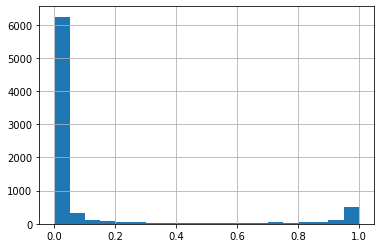

In [ ]:
# Vemos la distribución del score del modelo binario (cerca de 0 implica "no frac-hit", cerca de 1 "si frac-hit")
# Se evidencia que las proporciones son parecidas al dataset donde hay aprox 88% de eventos "no frac-hit"

pd.Series(score_bin_test).hist(bins=20)

In [ ]:
# Se imprimen las variables más importantes para el modelo regresivo
# Vemos que el valor anterior del delta_WHP y el score_binario son lo más importante

pd.Series(model_reg.get_feature_importance(), index=X_test.columns).nlargest(10)

ant_delta_WHP    19.902444
score_bin        15.367163
ETAPA_HIJO        9.436410
DZ                5.882248
D2D               5.564900
PAD_HIJO          5.304660
CAMPO             4.968928
D3D               4.757567
pct_dif_WHP_i     4.542595
WHP_i_std         3.951292
dtype: float64

## Proceso final de scoring

In [ ]:
# Se toma el df_total que une el train y evaluación, se eligen las variables utilizadas en el entrenamiento.
# Se calculan ambos scores y se genera el dataframe final

mask_eval = (df_total['TIPO'] == 'Eval')

X_eval = df_total.loc[mask_eval, ['CAMPO', 'PADRE', 'HIJO', 'PAD_HIJO',
                                  'FLUIDO', 'LINEAMIENTO', 'ESTADO',
                                  'ETAPA_HIJO', 'D3D', 'D2D', 'DZ', '#_BARRERAS', 'WHP_i', 'WHP_i_std',
                                  'pct_dif_D3D', 'pct_dif_D2D', 'pct_dif_DZ', 'pct_dif_WHP_i',
                                  'dif_ETAPA_HIJO', 'sen_AZ', 'cos_AZ', 'ant_delta_WHP',
                                ]]

score_bin_eval = model_bin.predict_proba(X_eval)[:,1]
X_eval['score_bin'] = score_bin_eval
score_reg_eval = model_reg.predict(X_eval)

df_final = pd.DataFrame(score_reg_eval, index=X_eval.index, columns=['reg'])
df_final['bin'] = score_bin_eval
df_final['ID_FILA'] = df_total['ID_FILA']
df_final['score_final'] = np.where(df_final['bin'] < 0.4, 0, df_final['reg'])
df_final.head()

,reg,bin,ID_FILA,score_final
13,3.156267,0.990528,31198,3.156267
16,13.911820,0.996891,31023,13.911820
27,2.052787,0.979326,31863,2.052787
28,12.220877,0.994554,30877,12.220877
30,8.895334,0.996478,30928,8.895334


Se exporta el CSV con el score final teniendo en cuenta ambos modelos

In [ ]:
# Acá termina lo "útil" solo queda exportar el CSV
# La puntuación final con este modelo es de 0.84

df_final[['ID_FILA', 'score_final']].to_csv('predicciones.csv', header=False, index=False)

Se genera el otro CSV que es el que se utiliza con el fin de tener mejor puntuación.

Dado que en el 1° meetup surgió la pregunta de si se podía usar información futura (delta_WHP de una ETAPA_HIJO posterior a la que se está evaluando) para predecir el delta_WHP y desde YPF dijeron que "sí"... Vamos a aprovechar para mejorar un poco el score...

In [ ]:
# Al score_final lo vamos a promediar con la media_movil y los valores anteriores / posteriores de delta_WHP
# Este nuevo score_trampita tiene un puntaje de 0.75

df_final['media_movil_delta_WHP'] = df_total['media_movil_delta_WHP']
df_final['pos_delta_WHP'] = df_total['pos_delta_WHP']
df_final['ant_delta_WHP'] = df_total['ant_delta_WHP']
df_final['score_trampita'] = np.where(df_final['bin'] < 0.4,
                                      0,
                                      np.where(pd.isna(df_final['media_movil_delta_WHP']),
                                               np.where(pd.isna(df_final['ant_delta_WHP']),
                                                        np.where(pd.isna(df_final['pos_delta_WHP']),
                                                                 df_final['score_final'],
                                                                 (df_final['score_final'] * 0.2 + df_final['pos_delta_WHP'] * 0.8)),
                                                        (df_final['score_final'] * 0.2 + df_final['ant_delta_WHP'] * 0.8)),
                                               (df_final['score_final'] * 0.2 + df_final['media_movil_delta_WHP'] * 0.8)))

df_final[['ID_FILA', 'score_trampita']].to_csv('predicciones_trampita.csv', header=False, index=False)
df_final[['ID_FILA', 'score_trampita']].head()

,ID_FILA,score_trampita
13,31198,1.351253
16,31023,12.382364
27,31863,3.050557
28,30877,9.804175
30,30928,6.259067
